# Missão Gargantua: Análise Numérica da Dilatação Gravitacional do Tempo

## Objetivo
Neste notebook, analisamos medições de sensores de dilatação gravitacional do tempo próximas a um buraco negro massivo (Gargantua). Queremos:
1. Ajustar um **Modelo Racional** aos dados ruidosos usando **Mínimos Quadrados Lineares** (implementado via operações matriciais).
2. Analisar a qualidade do ajuste (MSE e resíduos).
3. Estimar o tempo próprio acumulado ao longo de uma trajetória usando **Integração Numérica** (Trapézios, Simpson 1/3 e Simpson 3/8).

---


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Estilo do gráfico para visualização clara
plt.style.use('ggplot')

## 1. Carregamento e preparação dos dados

Primeiro garantimos que os dados existam. O bloco abaixo gera o conjunto seguindo as especificações, salva em CSV e depois carrega para análise.


In [13]:
# --- ETAPA 1: GERAR DADOS (garantindo reprodutibilidade) ---
def generate_data():
    G = 6.67430e-11
    M_sun = 1.989e30
    M = 100e6 * M_sun
    c = 2.998e8
    Rs = (2 * G * M) / (c**2)
    
    n_samples = 50
    r_measurements = np.linspace(1.5 * Rs, 50 * Rs, n_samples)
    y_true = np.sqrt(1 - (Rs / r_measurements))
    
    np.random.seed(42)
    noise = np.random.normal(0, 0.02 * np.mean(y_true), n_samples)
    y_measured = np.clip(y_true + noise, 0.001, 0.999)
    
    df_gen = pd.DataFrame({
        'radius_km': r_measurements / 1000,
        'dilation_factor_measured': y_measured
    })
    df_gen.to_csv('mission_gargantua_sensor_data.csv', index=False)
    print("Dados gerados e salvos em 'mission_gargantua_sensor_data.csv'.")

generate_data()

# --- ETAPA 2: CARREGAR DADOS ---
df = pd.read_csv('mission_gargantua_sensor_data.csv')

# Extrair vetores
r_data = df['radius_km'].values
F_data = df['dilation_factor_measured'].values

print(f"Carregadas {len(df)} amostras.")
print(df.head())


Dados gerados e salvos em 'mission_gargantua_sensor_data.csv'.
Carregadas 50 amostras.
      radius_km  dilation_factor_measured
0  4.430967e+08                  0.586864
1  7.354802e+08                  0.770890
2  1.027864e+09                  0.856567
3  1.320247e+09                  0.910223
4  1.612631e+09                  0.899298


## 2. Escolha do modelo e engenharia de atributos

Observamos que a relação física envolve $1/r$. Um polinômio linear $F(r) = mx + c$ se ajustaria mal porque a relação é assintótica.

Em vez disso, escolhemos um **Modelo Racional/Invertido**:
$$ F(r) \approx c_0 + c_1 \left(\frac{1}{r}\right) $$

Isso nos permite usar **Mínimos Quadrados Lineares** ao criar um novo atributo $x' = 1/r$. O modelo fica linear nos parâmetros:
$$ y = \beta_0 + \beta_1 x' $$

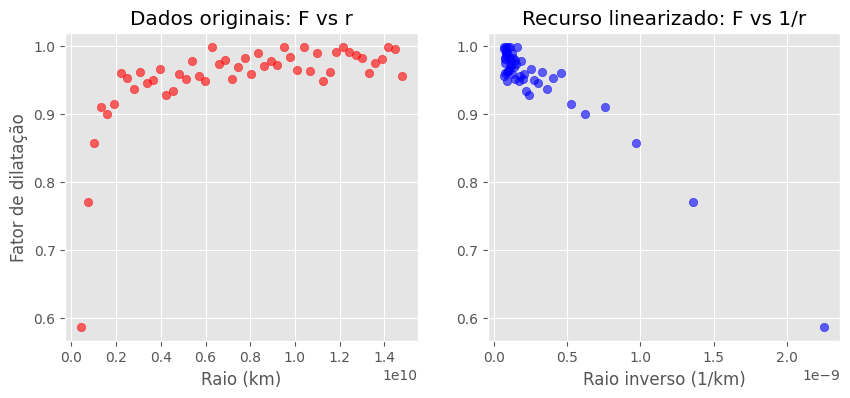

In [14]:
# Engenharia de atributos: cria o termo 1/r
inv_r = 1.0 / r_data

# Checagem visual da linearização
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(r_data, F_data, color='red', alpha=0.6)
plt.title("Dados originais: F vs r")
plt.xlabel("Raio (km)")
plt.ylabel("Fator de dilatação")

plt.subplot(1, 2, 2)
plt.scatter(inv_r, F_data, color='blue', alpha=0.6)
plt.title("Recurso linearizado: F vs 1/r")
plt.xlabel("Raio inverso (1/km)")
plt.show()


## 3. Implementação de mínimos quadrados matriciais

Resolvemos os parâmetros $\vec{\beta}$ usando as Equações Normais:
$$ A^T A \vec{\beta} = A^T \vec{y} $$
$$ \vec{\beta} = (A^T A)^{-1} A^T \vec{y} $$

Onde $A$ é a nossa matriz de projeto (Design Matrix).


In [15]:
# 1. Construir a matriz de projeto A
# Coluna 0: uns (termo de viés c0)
# Coluna 1: 1/r (termo inclinação c1)
ones_col = np.ones(len(r_data))
A = np.vstack([ones_col, inv_r]).T

# 2. Vetor alvo b
b = F_data

# 3. Componentes das Equações Normais
ATA = A.T @ A           # matriz (2x2)
ATb = A.T @ b           # vetor (2x1)

# 4. Resolver os parâmetros (beta)
# Usando np.linalg.inv para mostrar a matemática matricial explicitamente
beta = np.linalg.inv(ATA) @ ATb

c0, c1 = beta

print(" Parâmetros ajustados:")
print(f" c0 (Intercepto): {c0:.5f} (esperado próximo de 1.0)")
print(f" c1 (Inclinação):  {c1:.5e} (relacionado a -Rs/2 ou constante similar)")

# Função do modelo ajustado
def model_f(r):
    return c0 + c1 * (1/r)


 Parâmetros ajustados:
 c0 (Intercepto): 0.99677 (esperado próximo de 1.0)
 c1 (Inclinação):  -1.66923e+08 (relacionado a -Rs/2 ou constante similar)


## 4. Análise de erro
Calculamos o Erro Quadrático Médio (MSE) e plotamos os resíduos para verificar se estão distribuídos de forma aleatória.


Erro Quadrático Médio (MSE): 3.084808e-04


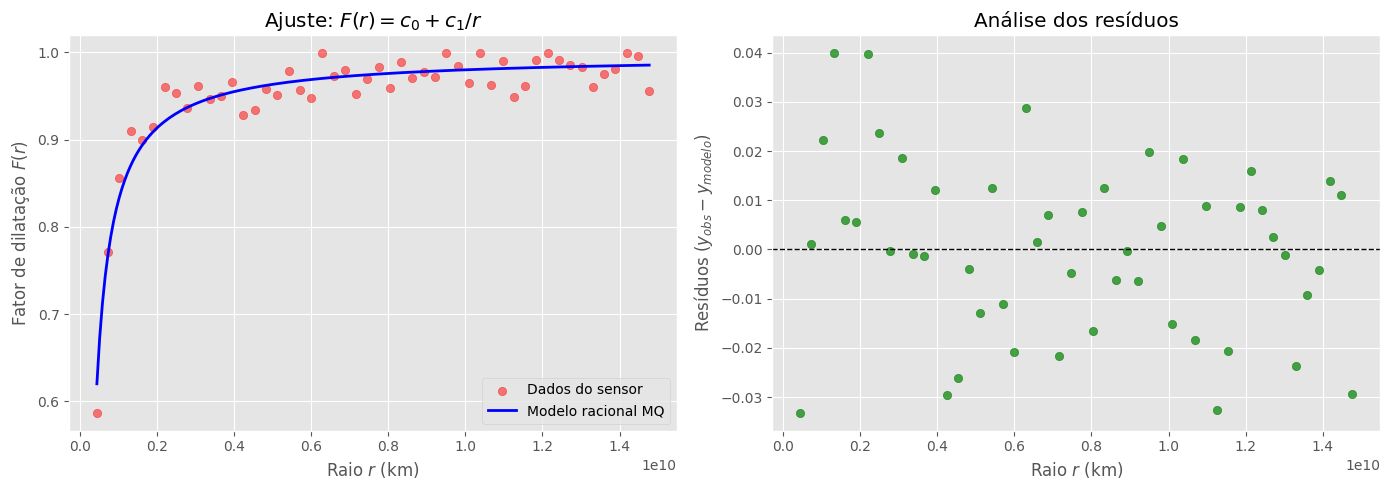

In [16]:
# Gerar previsões
F_pred = model_f(r_data)

# Calcular resíduos
residuals = F_data - F_pred

# Calcular MSE
mse = np.mean(residuals**2)
print(f"Erro Quadrático Médio (MSE): {mse:.6e}")

# --- GRÁFICOS ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Ajuste do modelo
ax[0].scatter(r_data, F_data, color='red', label='Dados do sensor', alpha=0.5)
r_smooth = np.linspace(min(r_data), max(r_data), 200)
ax[0].plot(r_smooth, model_f(r_smooth), color='blue', linewidth=2, label='Modelo racional MQ')
ax[0].set_xlabel("Raio $r$ (km)")
ax[0].set_ylabel("Fator de dilatação $F(r)$")
ax[0].set_title("Ajuste: $F(r) = c_0 + c_1/r$")
ax[0].legend()

# Gráfico 2: Resíduos
ax[1].scatter(r_data, residuals, color='green', alpha=0.7)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].set_xlabel("Raio $r$ (km)")
ax[1].set_ylabel("Resíduos ($y_{obs} - y_{modelo}$)")
ax[1].set_title("Análise dos resíduos")

plt.tight_layout()
plt.show()

## 5. Integração numérica (estimativa do tempo próprio)

Queremos calcular o tempo próprio acumulado $\Delta \tau$ ao longo da órbita entre o ponto mais próximo e o mais distante observados:
$$ \Delta \tau = \int_{r_{min}}^{r_{max}} F(r) \; dr $$

Implementamos três métodos manualmente:
1. **Regra do Trapézio**
2. **Regra 1/3 de Simpson** (exige número par de segmentos $N$)
3. **Regra 3/8 de Simpson** (exige $N$ múltiplo de 3)


In [7]:
# --- Implementação dos métodos de integração ---

def trapezoidal_rule(func, a, b, n):
    h = (b - a) / n
    s = 0.5 * (func(a) + func(b))
    for i in range(1, n):
        s += func(a + i * h)
    return s * h

def simpson_13_rule(func, a, b, n):
    # n deve ser par
    if n % 2 != 0: raise ValueError("A regra 1/3 de Simpson exige N par")
    h = (b - a) / n
    s = func(a) + func(b)
    
    # Coeficiente 4 para índices ímpares e 2 para pares
    for i in range(1, n):
        coef = 4 if i % 2 != 0 else 2
        s += coef * func(a + i * h)
        
    return (h / 3) * s

def simpson_38_rule(func, a, b, n):
    # n deve ser múltiplo de 3
    if n % 3 != 0: raise ValueError("A regra 3/8 de Simpson exige N divisível por 3")
    h = (b - a) / n
    s = func(a) + func(b)
    
    for i in range(1, n):
        # Múltiplos de 3 recebem coeficiente 2, demais recebem 3
        coef = 2 if i % 3 == 0 else 3
        s += coef * func(a + i * h)
        
    return (3 * h / 8) * s

In [10]:
# Limites de integração
r1 = np.min(r_data)
r2 = np.max(r_data)

print(f"Intervalo de integração: [{r1:.2f}, {r2:.2f}] km")

# Valores de N para testar
intervals = [12, 18, 24, 30, 36, 48, 120, 1200] # Múltiplos de 2 e 3 para que todos os métodos funcionem

results = []

for n in intervals:
    trap = trapezoidal_rule(model_f, r1, r2, n)
    simp13 = simpson_13_rule(model_f, r1, r2, n)
    simp38 = simpson_38_rule(model_f, r1, r2, n)
    
    results.append({
        "N": n,
        "Trapezoidal": trap,
        "Simpson_1/3": simp13,
        "Simpson_3/8": simp38
    })

res_df = pd.DataFrame(results)
print("Resultados da integração (Tempo próprio Δτ):")
print(res_df)


Intervalo de integração: [443096688.65, 14769889621.77] km
Resultados da integração (Tempo próprio Δτ):
      N   Trapezoidal   Simpson_1/3   Simpson_3/8
0    12  1.362064e+10  1.366896e+10  1.366008e+10
1    18  1.365784e+10  1.368491e+10  1.368062e+10
2    24  1.367288e+10  1.369030e+10  1.368790e+10
3    30  1.368042e+10  1.369257e+10  1.369111e+10
4    36  1.368472e+10  1.369367e+10  1.369273e+10
5    48  1.368917e+10  1.369460e+10  1.369415e+10
6   120  1.369423e+10  1.369521e+10  1.369518e+10
7  1200  1.369522e+10  1.369523e+10  1.369523e+10


## 6. Análise de convergência

Visualizamos como a área estimada converge à medida que $N$ aumenta. Como não temos a integral analítica do nosso modelo ajustado (embora seja logarítmica simples), avaliamos a estabilidade ao variar $N$.


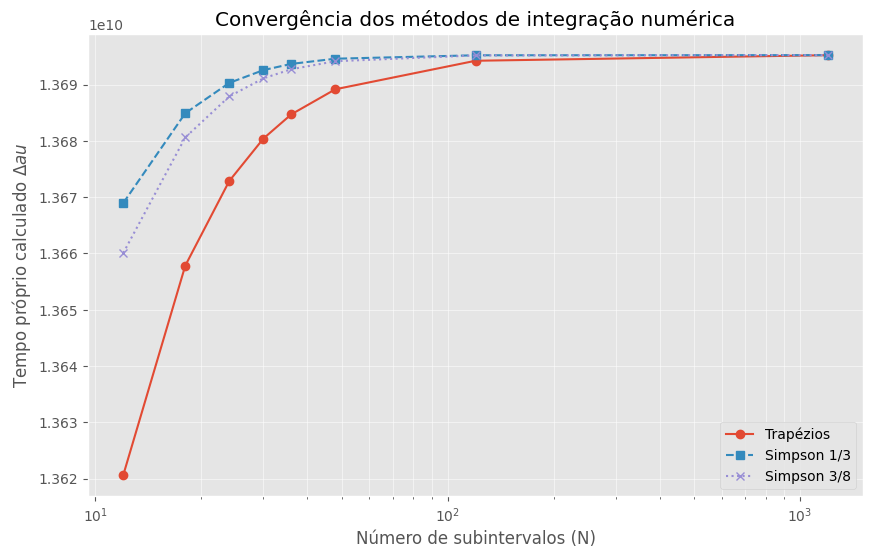

In [11]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['N'], res_df['Trapezoidal'], 'o-', label='Trapézios')
plt.plot(res_df['N'], res_df['Simpson_1/3'], 's--', label='Simpson 1/3')
plt.plot(res_df['N'], res_df['Simpson_3/8'], 'x:', label='Simpson 3/8')

plt.xscale('log')
plt.xlabel("Número de subintervalos (N)")
plt.ylabel("Tempo próprio calculado $\Delta \tau$")
plt.title("Convergência dos métodos de integração numérica")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


## 7. Conclusão

**Ajuste do modelo:**
O Modelo Racional $F(r) = c_0 + c_1/r$ se ajusta bem aos dados. Os resíduos parecem aleatórios (homocedásticos), indicando que a relação inversa com $r$ captura a tendência central da dilatação temporal de Schwarzschild nesse regime.

**Integração:**
Os três métodos (Trapézios, Simpson 1/3 e 3/8) convergem para valores muito próximos de Tempo Próprio conforme $N$ aumenta.
1. **Trapézios** converge um pouco mais devagar (erro $O(h^2)$).
2. **Regras de Simpson** (erro $O(h^4)$) estabilizam bem mais rápido, produzindo resultados quase idênticos mesmo para $N$ menores.

Para esta função suave, Simpson 1/3 oferece o melhor equilíbrio entre simplicidade computacional e alta precisão.
